In [24]:
import numpy as np
from astropy.table import Table
import thecannon as tc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#from mpi4py import MPI
import multiprocess as mp
from multiprocess import Pool
import os
import tqdm

## Let's start by training and testing only on giants with modest reddening (logg<3, Teff<5500K, A_v < 1)

Currently training on mock BP RP spectra from Maddie.  Ultimately, we will want to train directly on the Hermite coefficient matrices to save time.

In [25]:
#paths
table_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'
spec_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/' #assumes spec are in directory 'apogee' inside this path
fig_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'

Load in labels:

In [96]:
t1 = Table.read(table_path+'synth_apogee_0.fits', format='fits')
t = t1[t1['synth']]
#t_apogee = Table.read('apogee_good_0_w2m.fits', format='fits')


Load in spectra:

In [97]:
def read_in_data(i):
#     if i%1000 == 0:
#         print(str(np.round(100*i/size, 2))+'%', end='    \r')
    Teff = t['Teff'][i] ; logg = t['logg'][i] ; feh = t['feh'][i] ;  a = t['A_v'][i] ; s = t['SNR'][i]
    filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg),str(feh),str(a),str(s))
    try:
        w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
        wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
       
    except:  
        try:
            formatter = "{0:.12g}"
            Teff2 = formatter.format(Teff)
            logg2 = formatter.format(logg)
            feh2 = formatter.format(feh)
            s2 = formatter.format(s)
            a2 = formatter.format(a)
            filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s2))
            w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            
        except:
            try:
                formatter = "{0:.12g}"
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                s2 = formatter.format(s)
                a2 = formatter.format(a)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg2),str(feh2),str(a2),str(s2))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                
            except:
                formatter = "{0:.12g}"
                Teff2 = formatter.format(Teff)
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                a2 = formatter.format(a)
                s = "{0:.1f}".format(s)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)

#     w = w[~np.isnan(ebp)]
#     wr = wr[~np.isnan(erp)]
    fbp = fbp[~np.isnan(ebp)]
    ebp = ebp[~np.isnan(ebp)]
    frp = frp[~np.isnan(erp)]
    erp = erp[~np.isnan(erp)]
    
    f = np.concatenate([fbp,frp])
    errs = np.concatenate([ebp,erp])
    
#     f2 = np.concatenate([fbp,frp])
#     errsr = np.concatenate([ebp,erp])
    
    if i%1000 == 0:
        print(np.round(100*i/size, 2), '%')
    return [f, errs]


In [27]:
#loading in spec with max normalization
# size = len(t) #adjust if you only want to play with subset of data

# def read_in_data(i, photometry = False):
# #     if i%1000 == 0:
# #         print(str(np.round(100*i/size, 2))+'%', end='    \r')
#     Teff = t['Teff'][i] ; logg = t['logg'][i] ; feh = t['feh'][i] ;  a = t['A_v'][i] ; s = t['SNR'][i]
#     filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg),str(feh),str(a),str(s))
#     try:
#         w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
#         wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
       
#     except:  
#         try:
#             formatter = "{0:.12g}"
#             Teff2 = formatter.format(Teff)
#             logg2 = formatter.format(logg)
#             feh2 = formatter.format(feh)
#             s2 = formatter.format(s)
#             a2 = formatter.format(a)
#             filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s2))
#             w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
#             wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            
#         except:
#             try:
#                 formatter = "{0:.12g}"
#                 logg2 = formatter.format(logg)
#                 feh2 = formatter.format(feh)
#                 s2 = formatter.format(s)
#                 a2 = formatter.format(a)
#                 filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg2),str(feh2),str(a2),str(s2))
#                 w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
#                 wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                
#             except:
#                 formatter = "{0:.12g}"
#                 Teff2 = formatter.format(Teff)
#                 logg2 = formatter.format(logg)
#                 feh2 = formatter.format(feh)
#                 a2 = formatter.format(a)
#                 s = "{0:.1f}".format(s)
#                 filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s))
#                 w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
#                 wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)

# #     w = w[~np.isnan(ebp)]
# #     wr = wr[~np.isnan(erp)]
#     fbp = fbp[~np.isnan(ebp)]
#     ebp = ebp[~np.isnan(ebp)]
#     frp = frp[~np.isnan(erp)]
#     erp = erp[~np.isnan(erp)]
    
#     if photometry == True:
#         #add in photometry
#         photometry_vals = list(t_apogee['BP', 'RP','J', 'H', 'K', 'W1', 'W2', 'W3', 'W4'][i])
#         #fake bp rp errs for now
#         photometry_errs = list(t_apogee['BP_err', 'RP_err', 'J_err', 'H_err', 'K_err', 'W1_err', 'W2_err', 'W3_err', 'W4_err'][i])
    
#         f = np.concatenate([fbp,frp, photometry_vals])
#         errs = np.concatenate([ebp,erp, photometry_errs])
#     else:
#         f = np.concatenate([fbp,frp])
#         errs = np.concatenate([ebp,erp])
    
# #     f2 = np.concatenate([fbp,frp])
# #     errsr = np.concatenate([ebp,erp])
    
#     if i%1000 == 0:
#         print(np.round(100*i/size, 2), '%')
#     return [f, errs]

# def read_in_phot(i):
#     return read_in_data(i, photometry = True)
    
# def read_in_nophot(i):
#     return read_in_data(i, photometry = False)

# # fi, ei = read_in_data(5, photometry=True)
# # w_size_w_phot = len(fi)
# # fi, ei = read_in_data(5, photometry=False)
# # w_size_wo_phot = len(fi)

In [98]:
import time

start_time = time.time()
p = Pool(os.cpu_count()-2)
results = np.array(p.map(read_in_data, range(size)))
xs = np.array(results)[:,0,:]
xerrs = np.array(results)[:,1,:]
print(time.time() - start_time, ' s')


0.0 %
16.11 %
14.5 %
12.89 %
11.28 %
9.67 %
8.05 %
24.16 %
6.44 %
22.55 %
4.83 %
20.94 %
3.22 %
19.33 %
1.61 %
17.72 %
32.22 %
48.33 %
30.61 %
46.72 %
29.0 %
45.11 %
27.39 %
43.5 %
25.78 %
41.89 %
40.27 %
38.66 %
37.05 %
35.44 %
33.83 %
49.94 %
64.44 %
62.83 %
61.22 %
59.61 %
58.0 %
74.11 %
56.38 %
72.49 %
54.77 %
70.88 %
53.16 %
69.27 %
51.55 %
67.66 %
66.05 %
98.27 %
80.55 %
96.66 %
78.94 %
95.05 %
77.33 %
93.44 %
75.72 %
91.83 %
90.21 %
88.6 %
86.99 %
85.38 %
83.77 %
99.88 %
82.16 %
96.61395931243896  s


In [252]:
#add photometry
phots_matrix = np.zeros((xs.shape[0], 7))
photerrs_matrix = np.zeros((xs.shape[0], 7))
phots_matrix[:, 0] = np.array(t_apogee['BP']).astype(float)
phots_matrix[:, 1] = np.array(t_apogee['RP']).astype(float)
phots_matrix[:, 2] = np.array(t_apogee['J']).astype(float)
phots_matrix[:, 3] = np.array(t_apogee['H']).astype(float)
phots_matrix[:, 4] = np.array(t_apogee['K']).astype(float)
phots_matrix[:, 5] = np.array(t_apogee['W1']).astype(float)
phots_matrix[:, 6] = np.array(t_apogee['W2']).astype(float)
# phots_matrix[:, 7] = np.array(t_apogee['W3']).astype(float)
# phots_matrix[:, 8] = np.array(t_apogee['W4']).astype(float)

photerrs_matrix[:, 0] = np.array(t_apogee['BP_err']).astype(float)
photerrs_matrix[:, 1] = np.array(t_apogee['RP_err']).astype(float)
photerrs_matrix[:, 2] = np.array(t_apogee['J_err']).astype(float)
photerrs_matrix[:, 3] = np.array(t_apogee['H_err']).astype(float)
photerrs_matrix[:, 4] = np.array(t_apogee['K_err']).astype(float)
photerrs_matrix[:, 5] = np.array(t_apogee['W1_err']).astype(float)
photerrs_matrix[:, 6] = np.array(t_apogee['W2_err']).astype(float)
# photerrs_matrix[:, 7] = np.array(t_apogee['W3_err']).astype(float)
# photerrs_matrix[:, 8] = np.array(t_apogee['W4_err']).astype(float)


xs_with_phot = np.zeros((xs.shape[0],xs.shape[1]+7))
xerrs_with_phot = np.zeros((xs.shape[0],xs.shape[1]+7))

xs_with_phot[:,:xs.shape[1]] = xs
xerrs_with_phot[:,:xs.shape[1]] = xerrs

xs_with_phot[:,xs.shape[1]:] = phots_matrix
xerrs_with_phot[:,xs.shape[1]:] = photerrs_matrix
phots_matrix.shape, xs_with_phot.shape



((62074, 7), (62074, 904))

Choose subset of data for training and testing (uncomment relevant cell)

In [295]:
# # **Giants**

# subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 1) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs_with_phot[subset]
# xerrs_subset = xerrs_with_phot[subset]

((8503, 904), (8503, 904), 8503)

In [316]:
# # **Giants and Less Restrictive A_v

# subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 3) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]





In [339]:
# # **DWARFS**

# subset = np.where((t['Teff'] < 6500) & (t['Teff'] > 4500) & (t['logg'] > 4) & (t['A_v'] < 10) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs[subset]
# xerrs_subset = xerrs[subset]

In [347]:
# **Dwarfs+Giants**
subset = np.where((t['Teff'] < 6500) & (t['A_v'] < 10) & (t['A_v'] > 0))
t_subset = t[subset]
xs_subset = xs[subset]
xerrs_subset = xerrs[subset]

Normalize data according to desired scheme (max, min-max, deviation from mean, etc.)

In [348]:
#remove bad spectra
bad = np.where(np.isnan(np.mean(xs_subset,axis=1)))
xs_subset = np.delete(xs_subset, bad, axis=0)
xerrs_subset = np.delete(xerrs_subset, bad, axis=0)
t_subset.remove_rows(bad[0])

bad = np.where(np.isnan(np.mean(xs_subset,axis=1)))
xs_subset = np.delete(xs_subset, bad, axis=0)
xerrs_subset = np.delete(xerrs_subset, bad, axis=0)
t_subset.remove_rows(bad[0])

xs_subset.shape, xerrs_subset.shape, len(t_subset)

# min max norm of each pixel

# for i in range(xs_subset.shape[1]):
#     xs_subset[:,i] = (xs_subset[:,i] - np.nanmin(xs_subset[:,i])) / (np.nanmax(xs_subset[:,i]) - np.nanmin(xs_subset[:,i]))
#     xerrs_subset[:,i] = 1/np.sqrt(xerrs_subset[:,i]/(np.nanmax(xs_subset[:,i]) - np.nanmin(xs_subset[:,i])))

# mean of each pixel norm
for i in range(xs_subset.shape[1]):
    xs_subset[:,i] = xs_subset[:,i] / np.mean(xs_subset,axis=1)
    xerrs_subset[:,i] = 1/np.sqrt(xerrs_subset[:,i]/np.mean(xs_subset,axis=1))
#     if i > 890:
#         print(i, np.mean(xs_subset,axis=1))
#         print(np.where(np.isnan(xerrs_subset[:,i])))
    
#xs_subset = xs_subset/np.nanmean()
    
# max norm of each spectrum

# for i in range(xs_subset.shape[0]):
#     xs_subset[i,:] = xs_subset[i,:] / np.max(xs_subset[i,:])
#     xerrs_subset[i,:] = 1/np.sqrt(xerrs_subset[i,:] / np.max(xs_subset[i,:]))
# xs_subset.shape[0]

xs_subset.shape

(57660, 897)

Plot some spectra just to see what they look like:

In [349]:
%matplotlib inline
# teffs = t_subset['Teff']
# loggs = t_subset['logg']
# fehs = t_subset['feh']
# avs = t_subset['A_v']
# snrs = t_subset['SNR']

# xs_smooth = xs_subset[i]


# #remove overlap if desired
# # lo = 310
# # up = 450
# # end = -9
#if you don't want to remove overlap:
# lo = 0
# up = 0
# end = len(wf)

# #plot a few spectra
# plt.figure(figsize=(12,5))
# N=1
# for i in range(8):
#     plt.plot(wf[:lo], xs_subset[i][:lo], label=t_subset['A_v'][i])
#     plt.plot(wf[up:end], xs_subset[i][up:end], label=t_subset['A_v'][i])
# plt.legend(title="A_v")
# plt.show()

# wf_clean = np.concatenate([wf[:lo], wf[up:end]])

# xs_subset_clean = np.zeros((len(xs_subset),len(wf_clean)))
# xs_subset_clean[:,:lo] = xs_subset[:,:lo]
# xs_subset_clean[:,lo:] = xs_subset[:,up:end]
# xerrs_subset_clean = np.zeros((len(xs_subset),len(wf_clean)))
# xerrs_subset_clean[:,:lo] = xerrs_subset[:,:lo]
# xerrs_subset_clean[:,lo:] = xerrs_subset[:,up:end]

Separate training and testing sets, reassign NaN and inf values:

In [350]:
#making training and testing sets
# train_inds = np.random.choice(range(len(t)),int(.6*len(t)),replace=False)
# test_inds = np.array(list(set(range(len(t)))- set(train_inds)),dtype='int')
print(len(t), len(t[subset]))

np.random.seed(777) # For reproducibility.
q = np.random.randint(0, 10, len(t_subset)) % 10
validate_set = np.where((q<=2))[0]
train_set = np.where((q>2))[0]
train_inds = train_set
test_inds = validate_set

train_xs = xs_subset[train_inds]
train_errs = xerrs_subset[train_inds]
# bad = np.where(np.isnan(train_xs))
# train_xs[bad] = 0.0000001
# bad = np.where(np.isnan(train_errs))
# train_errs[bad] = 0.0000001
bad = np.where(train_xs==np.inf)
train_xs[bad] = 1e6
bad = np.where(train_errs==np.inf)
train_errs[bad] = 1e6
bad = np.where(np.isnan(train_errs))
train_errs[bad] = 1e-6

test_xs = xs_subset[test_inds]
test_errs = xerrs_subset[test_inds]
# bad = np.where(np.isnan(test_xs))
# test_xs[bad] = 0.0000001
# bad = np.where(np.isnan(test_errs))
# test_errs[bad] = 0.0000001
bad = np.where(test_xs==np.inf)
test_xs[bad] = 1e6
bad = np.where(test_errs==np.inf)
test_errs[bad] = 1e6

train_t = t_subset[train_inds]
test_t = t_subset[test_inds]

print(len(train_t), len(test_t))

np.where(np.isnan(train_errs))

62074 57660
40469 17191


(array([], dtype=int64), array([], dtype=int64))

Specify vectorizer, set up and train the model:

In [351]:
# # Specify the vectorizer.
# vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)
# # set up model
# model = tc.CannonModel(train_t, train_xs, train_errs,
#                        vectorizer=vectorizer, dispersion=wf)


vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)

model = tc.CannonModel(train_t, train_xs, train_errs, vectorizer=vectorizer)
# # No regularization.
model.regularization = 0

# Train the model!
model.train()


2022-06-07 23:49:04,899 [INFO] Training 4-label CannonModel with 40469 stars and 897 pixels/star
stty: stdin isn't a terminal2022-06-07 23:49:04,933 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[                                                                                                    ]   1% (7/897)                          

[================================================================================================================] 100% (15s)                              


(array([[ 1.01785045e-03,  2.41078506e-03,  7.53122234e-04, ...,
         -1.47688708e-04,  8.57830398e-04,  1.18695487e-03],
        [ 1.99521955e-03,  4.49781062e-03,  1.55225063e-03, ...,
         -5.19412579e-04,  1.60863145e-03,  2.52268513e-03],
        [ 3.65889583e-03,  8.26028213e-03,  2.88729876e-03, ...,
         -9.11731680e-04,  3.11955746e-03,  4.18410435e-03],
        ...,
        [ 3.88761852e+01,  4.77869469e+01, -1.61983627e+00, ...,
          1.61311345e+00, -1.22103790e+00,  1.62478489e+01],
        [ 3.51838625e+01,  4.55323007e+01, -1.61395774e+00, ...,
          1.51961367e+00, -8.71740853e-01,  1.54824452e+01],
        [ 3.14075021e+01,  4.26337889e+01, -1.58644063e+00, ...,
          1.41055433e+00, -5.51558267e-01,  1.44637076e+01]]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.000

Test the model:

In [352]:
#infer for train
test_labels, cov, metadata = model.test(test_xs, test_errs)


#fig_comparison = tc.plot.one_to_one(model, test_labels, latex_label_names=[r"T_{\rm eff}",r"\log{g}",r"[{\rm Fe}/{\rm H}]",r"{\rm A_V}"])
#fig_comparison.savefig(fig_path+"one-to-one.png", dpi=300)

2022-06-07 23:49:20,867 [DEBUG] Couldn't get screen size. Progressbar may look odd.
stty: stdin isn't a terminal
2022-06-07 23:49:20,871 [INFO] Running test step on 17191 spectra


[====================================================================================================] 100% (189s)                                 


Plot difference between true and inferred values:

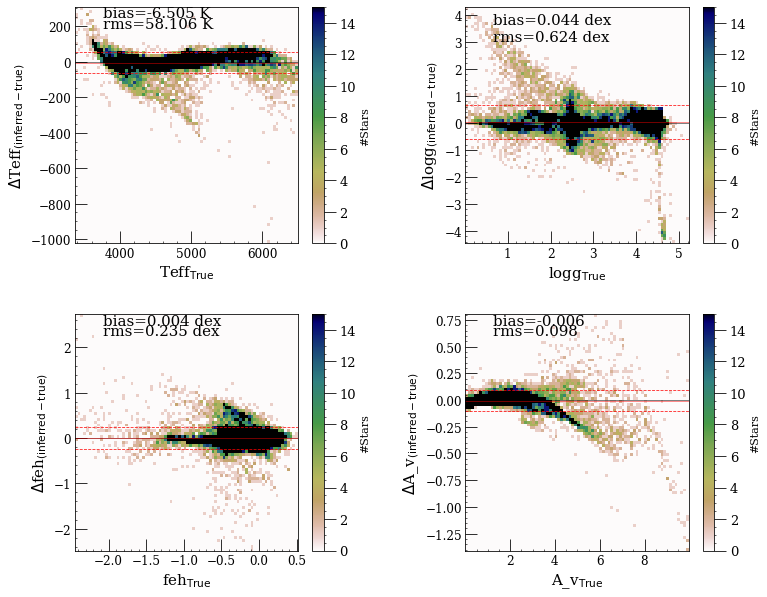

In [353]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 11}

import matplotlib
fig, axs = plt.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
plt.rc('font', **font)
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["xtick.minor.visible"] =  True

    
unit = ['K', 'dex', 'dex', '']
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hist2d(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], bins=80,  cmap='gist_earth_r', vmin=0, vmax=15)
    ax.axhline(y=0, c='k', alpha=.99, lw=.5)
    bias = np.round(np.mean(test_labels[:,i] - t_subset[param][test_inds]), 3)
    rms = np.round(np.std(test_labels[:,i] - t_subset[param][test_inds]), 3)
    ax.axhline(y=bias, c='r', alpha=.9, lw=.5)
    ax.axhline(y=bias+rms, c='r', alpha=.9, lw=.8, ls='--')
    ax.axhline(y=bias-rms, c='r', alpha=.9, lw=.8, ls='--')
    offset = (np.max(t_subset[param][test_inds]) - np.min(t_subset[param][test_inds]))/8
    ax.text(offset+np.min(t_subset[param][test_inds]), np.max(test_labels[:,i] - t_subset[param][test_inds])-rms, "bias={a} {b}".format(a=bias, b=unit[i]), fontsize=15)
    ax.text(offset+np.min(t_subset[param][test_inds]), np.max(test_labels[:,i] - t_subset[param][test_inds])-(2*rms), "rms={a} {b}".format(a=rms, b=unit[i]), fontsize=15)
    #ax.text(0.1, 0.8, "rms={}".format(rms))
    cbar = fig.colorbar(h[3], ax=ax, label='#Stars')
    cbar.ax.tick_params(labelsize=13) 
    #ax.set_title(param)
    ax.set_xlabel(param+r"$\rm _{{}True{}}$", fontsize=15)
    ax.set_ylabel(r"$\rm \Delta$"+param+r"$\rm _{(inferred - true)}$", fontsize=15)
    ax.tick_params(axis="both", which='both', direction="in")
plt.savefig("Diagnostic_Figs/wise2mass_normmean/inferred_vs_true_giantsAv10_hist2d.pdf")



# Ignore below

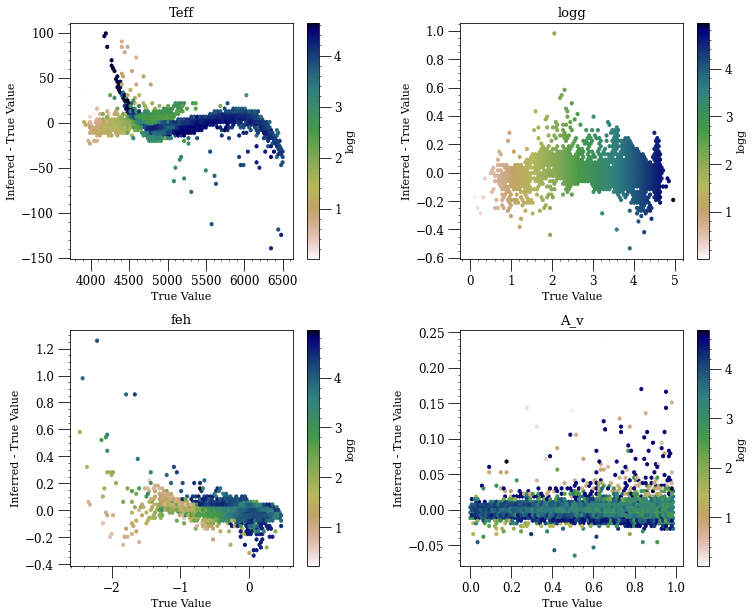

In [159]:
fig, axs = plt.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], gridsize=70, C=t_subset['logg'][test_inds], cmap='gist_earth_r')
    fig.colorbar(h, ax=ax, label='logg')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
#plt.savefig("Diagnostic_Figs/inferred_vs_true_giants_colorlogg.pdf")

In [ ]:
fig, axs = p.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], gridsize=40, C=t_subset['Teff'][test_inds])
    fig.colorbar(h, ax=ax, label='Teff')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
p.savefig("Diagnostic_Figs/inferred_vs_true_giants_colorTeff.pdf")

Histograms of inferred and true values

In [ ]:
fig, axs = p.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    ax.hist(test_labels[:,i], alpha=.5, label='Inferred', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.hist(t_subset[param][test_inds], alpha=.5, label='True', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.set_title(param)
    ax.legend()

In [ ]:
print(np.mean(test_labels[:,0]))
print(np.mean(np.abs(test_labels[:,0]-t_subset['Teff'][test_inds])))
print(np.mean(np.abs(test_labels[:,1]-t_subset['logg'][test_inds])))
print(np.mean(t_subset['Teff'][test_inds]))

In [ ]:
print(np.min(t_subset['Teff'][test_inds]), np.max(t_subset['Teff'][test_inds]))
print(np.min(t_subset['Teff'][train_inds]), np.max(t_subset['Teff'][train_inds]))

In [ ]:
t = Table.read(table_path+'synth_apogee_0.fits')
t = t[t['synth']]
t_apogee = Table.read(table_path+'apogee_good_0.fits')
t_apogee_reordered = t_apogee

goods = []
for i in range(len(t)):
    if i%1000 == 0:
        print(i)
    spot = np.where((np.round(t_apogee['TEFF'], 2) == np.round(t['Teff'][i], 2)) & (np.round(t_apogee['LOGG'], 2) == np.round(t['logg'][i], 2)) & (np.round(t_apogee['M_H'], 3) == np.round(t['feh'][i], 3)) & (np.round(t_apogee['SNR'], 3) == np.round(t['SNR'][i], 3)))
    if len(spot[0]) == 1:
        spot = spot[0][0]
        #print(t['Teff'][i], t_apogee['TEFF'][spot])
        t_apogee_reordered[i] = t_apogee[spot]
        #print(t_apogee_reordered['TEFF'][i])
        goods.append(i)

print(len(goods))

t[goods].write(table_path+'synth_apogee_good.fits', format='fits', overwrite=True)
t_apogee_reordered[goods].write(table_path+'apogee_info_good.fits', format='fits', overwrite=True)
#np.round(t['Teff'][5], 2), np.round(t_apogee['TEFF'][5], 2)

In [ ]:
t_apogee = Table.read(table_path+'apogee_info_good.fits')
t_apogee_2mass_wise = Table.read(table_path+'apogee_2mass_wise.fits')

t_apogee['J'], t_apogee['H'], t_apogee['K'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))
t_apogee['W1'], t_apogee['W2'], t_apogee['W3'], t_apogee['W4'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))

t_apogee['J_err'], t_apogee['H_err'], t_apogee['K_err'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))
t_apogee['W1_err'], t_apogee['W2_err'], t_apogee['W3_err'], t_apogee['W4_err'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))


#t_apogee_2mass_wise['W3mag'][(t_apogee_2mass_wise['W3mag'] == np.empty).mask]

for i, ID in enumerate(t_apogee['APOGEE_ID'][:]):
    if i % 1000 == 0:
        print(np.round(100 * ind/len(t_apogee), 2))
    if ID in t_apogee_2mass_wise['APOGEE_ID']:
        spot = np.where(t_apogee_2mass_wise['APOGEE_ID'] == ID)
        if (spot[0].size>0):
            if (spot[0].size==1):
                if (t_apogee_2mass_wise['W3mag'][spot] != np.empty) & (t_apogee_2mass_wise['W4mag'][spot] != np.empty):
                    t_apogee['J'][i] = t_apogee_2mass_wise['Jmag'][spot]
                    t_apogee['H'][i] = t_apogee_2mass_wise['Hmag'][spot]
                    t_apogee['K'][i] = t_apogee_2mass_wise['Kmag'][spot]
                    t_apogee['W1'][i] = t_apogee_2mass_wise['W1mag'][spot]
                    t_apogee['W2'][i] = t_apogee_2mass_wise['W2mag'][spot]
                    t_apogee['W3'][i] = t_apogee_2mass_wise['W3mag'][spot]
                    t_apogee['W4'][i] = t_apogee_2mass_wise['W4mag'][spot]
                    t_apogee['J_err'][i] = t_apogee_2mass_wise['e_Jmag'][spot]
                    t_apogee['H_err'][i] = t_apogee_2mass_wise['e_Hmag'][spot]
                    t_apogee['K_err'][i] = t_apogee_2mass_wise['e_Kmag'][spot]
                    t_apogee['W1_err'][i] = t_apogee_2mass_wise['e_W1mag'][spot]
                    t_apogee['W2_err'][i] = t_apogee_2mass_wise['e_W2mag'][spot]
                    t_apogee['W3_err'][i] = t_apogee_2mass_wise['e_W3mag'][spot]
                    t_apogee['W4_err'][i] = t_apogee_2mass_wise['e_W4mag'][spot]
            else:
                spot = spot[0][0]
                t_apogee['J'][i] = t_apogee_2mass_wise['Jmag'][spot]
                t_apogee['H'][i] = t_apogee_2mass_wise['Hmag'][spot]
                t_apogee['K'][i] = t_apogee_2mass_wise['Kmag'][spot]
                t_apogee['W1'][i] = t_apogee_2mass_wise['W1mag'][spot]
                t_apogee['W2'][i] = t_apogee_2mass_wise['W2mag'][spot]
                t_apogee['W3'][i] = t_apogee_2mass_wise['W3mag'][spot]
                t_apogee['W4'][i] = t_apogee_2mass_wise['W4mag'][spot]
                t_apogee['J_err'][i] = t_apogee_2mass_wise['e_Jmag'][spot]
                t_apogee['H_err'][i] = t_apogee_2mass_wise['e_Hmag'][spot]
                t_apogee['K_err'][i] = t_apogee_2mass_wise['e_Kmag'][spot]
                t_apogee['W1_err'][i] = t_apogee_2mass_wise['e_W1mag'][spot]
                t_apogee['W2_err'][i] = t_apogee_2mass_wise['e_W2mag'][spot]
                t_apogee['W3_err'][i] = t_apogee_2mass_wise['e_W3mag'][spot]
                t_apogee['W4_err'][i] = t_apogee_2mass_wise['e_W4mag'][spot]

t_apogee

In [ ]:
t_apogee.write('apogee_info_good_2mass_wise.fits', format='fits', overwrite=True)

In [ ]:
# def func1():
#     print('func1: starting')
#     for i in xrange(10000000): pass
#     print('func1: finishing')

# def func2():
#     print('func2: starting')
#     for i in xrange(10000000): pass
#     print('func2: finishing')

# p1 = Process(target=func1)
# p1.start()
# p2 = Process(target=func2)
# p2.start()
# p1.join()
# p2.join()

In [ ]:
t_apogee = Table.read(table_path+'apogee_good_0.fits', format='fits')
t_wise2mass = Table.read(table_path+'apogee_good_0_wise2mass.fits', format='fits')['APOGEE_ID','W1mag', 'e_W1mag', 'W2mag', 'e_W2mag','W3mag', 'e_W3mag', 'W4mag', 'e_W4mag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag']
t_apogee = t_apogee[t1['synth']]

#add 2mass wise data
t_wise2mass = Table.read(table_path+'apogee_good_0_wise2mass.fits', format='fits')['APOGEE_ID','W1mag', 'e_W1mag', 'W2mag', 'e_W2mag','W3mag', 'e_W3mag', 'W4mag', 'e_W4mag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag']
t_apogee['W1'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W2'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W3'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W4'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W1_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W2_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W3_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W4_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['J'] = np.repeat(np.nan, len(t_apogee))
t_apogee['H'] = np.repeat(np.nan, len(t_apogee))
t_apogee['K'] = np.repeat(np.nan, len(t_apogee))
t_apogee['J_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['H_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['K_err'] = np.repeat(np.nan, len(t_apogee))

for i in range(len(t_apogee)):
    if i%1000 == 0:
        print(100*i/len(t_apogee))
    if t_apogee['APOGEE_ID'][i] in t_wise2mass['APOGEE_ID']:
        spot = np.where((t_wise2mass['APOGEE_ID'] == t_apogee['APOGEE_ID'][i]))[0][0]
        t_apogee['W1'][i] = t_wise2mass['W1mag'][spot]
        t_apogee['W1_err'][i] = t_wise2mass['e_W1mag'][spot]
        t_apogee['W2'][i] = t_wise2mass['W2mag'][spot]
        t_apogee['W2_err'][i] = t_wise2mass['e_W2mag'][spot]
        t_apogee['W3'][i] = t_wise2mass['W3mag'][spot]
        t_apogee['W3_err'][i] = t_wise2mass['e_W3mag'][spot]
        t_apogee['W4'][i] = t_wise2mass['W4mag'][spot]
        t_apogee['W4_err'][i] = t_wise2mass['e_W4mag'][spot]
        t_apogee['J'][i] = t_wise2mass['Jmag'][spot]
        t_apogee['J_err'][i] = t_wise2mass['e_Jmag'][spot]
        t_apogee['H'][i] = t_wise2mass['Hmag'][spot]
        t_apogee['H_err'][i] = t_wise2mass['e_Hmag'][spot]
        t_apogee['K'][i] = t_wise2mass['Kmag'][spot]
        t_apogee['K_err'][i] = t_wise2mass['e_Kmag'][spot]
        
#fake bp rp errors
t_apogee['BP'] = t_apogee['GAIAEDR3_PHOT_BP_MEAN_MAG']
t_apogee['RP'] = t_apogee['GAIAEDR3_PHOT_RP_MEAN_MAG']
t_apogee['BP_err'] = t_apogee['J_err']
t_apogee['RP_err'] = t_apogee['J_err']

t_apogee.write('apogee_good_0_w2m.fits', format='fits', overwrite=True)